# Example

This package allows defining your inference problem with:

* the [PyMC](https://docs.pymc.io/) probabilistic programming language
* by coding up the posterior by-hand and using [Jax](https://jax.readthedocs.io/) to automatically compute the necessary posterior gradients
* by specifying the posterior and its gradients completely by-hand

We'll start withPyMC, since it is the easiest. First, load up the relevant packages:

In [1]:
%pylab inline
from scipy import stats
import pymc as pm
from ttictoc import tic, toc
from muse_inference.pymc import PyMCMuseProblem

Populating the interactive namespace from numpy and matplotlib


In [2]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight', 'dpi': 110}
%load_ext autoreload
%autoreload 2

As an example, consider the following hierarchical problem, which has the classic [Neal's Funnel](https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html) problem embedded in it. Neal's funnel is a standard example of a non-Gaussian latent space which HMC struggles to sample efficiently without extra tricks. Specifically, we consider the model defined by:

$$
\begin{aligned}
\theta &\sim {\rm Normal(0,3)} \\ 
z_i &\sim {\rm Normal}(0,\exp(\theta/2)) \\ 
x_i &\sim {\rm Normal}(z_i, 1)
\end{aligned}
$$

for $i=1...2048$. This problem can be described by the following PyMC model:

In [3]:
def gen_funnel(x=None, θ=None, rng_seeder=None):
    with pm.Model(rng_seeder=rng_seeder) as funnel:
        θ = pm.Normal("θ", mu=0, sigma=3) if θ is None else θ
        z = pm.Normal("z", mu=0, sigma=np.exp(θ/2), size=10000)
        x = pm.Normal("x", mu=z, sigma=1, observed=x)
    return funnel

Next, lets choose a true value of $\theta=0$ and generate some simulated data, $x$, which we'll use as "observations":

In [4]:
rng = np.random.RandomState(0)
x_obs = pm.sample_prior_predictive(1, model=gen_funnel(θ=0, rng_seeder=rng)).prior.x[0,0]
model = gen_funnel(x=x_obs, rng_seeder=rng)

We can run HMC on the problem to compute the "true" answer to compare against:

In [5]:
tic()
with model:
    chain = pm.sample(500, tune=500, cores=1, chains=1, discard_tuned_samples=False)
t_hmc = toc()

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Sequential sampling (1 chains in 1 job)


NUTS: [θ, z]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 17 seconds.


Only one chain was sampled, this makes it impossible to run some convergence checks


We next compute the MUSE estimate for the same problem. To reach the same Monte Carlo error as HMC, the number of MUSE simulations should be the same as the effective sample size of the chain we just ran. This is:

In [6]:
nsims = int(pm.ess(chain)["θ"])
nsims

83

Running the MUSE estimate, 

In [7]:
prob = PyMCMuseProblem(model)
tic()
result = prob.solve(θ_start=0, rng=np.random.SeedSequence(1), progress=True)
t_muse = toc()

MUSE:   0%|          | 0/5050 [00:00<?, ?it/s]

MUSE:   0%|          | 5/5050 [00:00<02:48, 30.00it/s]

MUSE:   0%|          | 14/5050 [00:00<01:30, 55.72it/s]

MUSE:   0%|          | 21/5050 [00:00<01:43, 48.80it/s]

MUSE:   1%|          | 30/5050 [00:00<01:23, 59.88it/s]

MUSE:   1%|          | 37/5050 [00:00<01:37, 51.66it/s]

MUSE:   1%|          | 46/5050 [00:00<01:23, 59.94it/s]

MUSE:   1%|          | 53/5050 [00:01<01:35, 52.48it/s]

MUSE:   1%|          | 62/5050 [00:01<01:22, 60.39it/s]

MUSE:   1%|▏         | 69/5050 [00:01<01:33, 53.16it/s]

MUSE:   2%|▏         | 78/5050 [00:01<01:22, 60.48it/s]

MUSE:   2%|▏         | 85/5050 [00:01<01:32, 53.51it/s]

MUSE:   2%|▏         | 94/5050 [00:01<01:37, 51.08it/s]

MUSE:   2%|▏         | 102/5050 [00:02<02:21, 35.05it/s]

MUSE:   2%|▏         | 108/5050 [00:02<02:16, 36.13it/s]

MUSE:   2%|▏         | 117/5050 [00:02<01:49, 45.24it/s]

MUSE:   2%|▏         | 123/5050 [00:02<01:53, 43.51it/s]

MUSE:   3%|▎         | 132/5050 [00:02<01:33, 52.53it/s]

MUSE:   3%|▎         | 139/5050 [00:02<01:41, 48.56it/s]

MUSE:   3%|▎         | 148/5050 [00:02<01:26, 56.89it/s]

MUSE:   3%|▎         | 155/5050 [00:03<01:33, 52.18it/s]

MUSE:   3%|▎         | 164/5050 [00:03<01:21, 60.03it/s]

MUSE:   3%|▎         | 171/5050 [00:03<01:31, 53.39it/s]

MUSE:   4%|▎         | 180/5050 [00:03<01:19, 61.17it/s]

MUSE:   4%|▎         | 187/5050 [00:03<01:29, 54.20it/s]

MUSE:   4%|▍         | 196/5050 [00:03<01:18, 62.02it/s]

MUSE:   4%|▍         | 203/5050 [00:04<02:24, 33.46it/s]

MUSE:   4%|▍         | 211/5050 [00:04<02:14, 36.10it/s]

MUSE:   4%|▍         | 220/5050 [00:04<01:48, 44.62it/s]

MUSE:   4%|▍         | 227/5050 [00:04<01:49, 43.96it/s]

MUSE:   5%|▍         | 236/5050 [00:04<01:32, 52.20it/s]

MUSE:   5%|▍         | 243/5050 [00:04<01:39, 48.32it/s]

MUSE:   5%|▍         | 252/5050 [00:05<01:25, 56.09it/s]

MUSE:   5%|▌         | 259/5050 [00:05<01:34, 50.73it/s]

MUSE:   5%|▌         | 268/5050 [00:05<01:21, 58.36it/s]

MUSE:   5%|▌         | 275/5050 [00:05<01:32, 51.70it/s]

MUSE:   6%|▌         | 284/5050 [00:05<01:20, 59.09it/s]

MUSE:   6%|▌         | 291/5050 [00:05<01:31, 52.18it/s]

MUSE:   6%|▌         | 300/5050 [00:06<01:36, 49.44it/s]

MUSE:   6%|▌         | 306/5050 [00:06<02:24, 32.86it/s]

MUSE:   6%|▌         | 314/5050 [00:06<02:14, 35.30it/s]

MUSE:   6%|▋         | 323/5050 [00:06<01:47, 44.02it/s]

MUSE:   7%|▋         | 329/5050 [00:06<01:51, 42.16it/s]

MUSE:   7%|▋         | 338/5050 [00:06<01:32, 50.97it/s]

MUSE:   7%|▋         | 345/5050 [00:07<01:38, 47.81it/s]

MUSE:   7%|▋         | 354/5050 [00:07<01:23, 56.20it/s]

MUSE:   7%|▋         | 361/5050 [00:07<01:32, 50.63it/s]

MUSE:   7%|▋         | 370/5050 [00:07<01:19, 58.62it/s]

MUSE:   7%|▋         | 377/5050 [00:07<01:29, 51.98it/s]

MUSE:   8%|▊         | 386/5050 [00:07<01:17, 59.80it/s]

MUSE:   8%|▊         | 393/5050 [00:07<01:26, 53.65it/s]

MUSE:   8%|▊         | 402/5050 [00:08<01:30, 51.38it/s]

MUSE:   8%|▊         | 408/5050 [00:08<02:17, 33.72it/s]

MUSE:   8%|▊         | 416/5050 [00:08<02:06, 36.67it/s]

MUSE:   8%|▊         | 426/5050 [00:08<01:39, 46.64it/s]

MUSE:   9%|▊         | 432/5050 [00:08<01:42, 45.01it/s]

MUSE:   9%|▉         | 442/5050 [00:09<01:23, 55.08it/s]

MUSE:   9%|▉         | 449/5050 [00:09<01:28, 51.91it/s]

MUSE:   9%|▉         | 459/5050 [00:09<01:15, 61.09it/s]

MUSE:   9%|▉         | 466/5050 [00:09<01:23, 55.20it/s]

MUSE:   9%|▉         | 476/5050 [00:09<01:25, 53.69it/s]

MUSE:  10%|▉         | 486/5050 [00:09<01:13, 62.12it/s]

MUSE:  10%|▉         | 493/5050 [00:09<01:22, 55.52it/s]

MUSE:  10%|▉         | 503/5050 [00:10<01:11, 63.82it/s]

MUSE:  10%|█         | 510/5050 [00:10<02:09, 35.00it/s]

MUSE:  10%|█         | 519/5050 [00:10<01:57, 38.47it/s]

MUSE:  10%|█         | 529/5050 [00:10<01:34, 47.64it/s]

MUSE:  11%|█         | 536/5050 [00:10<01:37, 46.13it/s]

MUSE:  11%|█         | 545/5050 [00:11<01:23, 54.27it/s]

MUSE:  11%|█         | 552/5050 [00:11<01:28, 50.79it/s]

MUSE:  11%|█         | 562/5050 [00:11<01:14, 59.90it/s]

MUSE:  11%|█▏        | 569/5050 [00:11<01:22, 54.21it/s]

MUSE:  11%|█▏        | 579/5050 [00:11<01:25, 52.31it/s]

MUSE:  12%|█▏        | 588/5050 [00:11<01:14, 59.57it/s]

MUSE:  12%|█▏        | 595/5050 [00:12<01:24, 52.79it/s]

MUSE:  12%|█▏        | 604/5050 [00:12<01:13, 60.33it/s]

MUSE:  12%|█▏        | 611/5050 [00:12<02:12, 33.43it/s]

MUSE:  12%|█▏        | 620/5050 [00:12<01:45, 41.88it/s]

MUSE:  12%|█▏        | 627/5050 [00:12<01:46, 41.50it/s]

MUSE:  13%|█▎        | 636/5050 [00:12<01:27, 50.22it/s]

MUSE:  13%|█▎        | 643/5050 [00:13<01:33, 47.23it/s]

MUSE:  13%|█▎        | 652/5050 [00:13<01:18, 55.94it/s]

MUSE:  13%|█▎        | 659/5050 [00:13<01:27, 50.35it/s]

MUSE:  13%|█▎        | 668/5050 [00:13<01:30, 48.52it/s]

MUSE:  13%|█▎        | 677/5050 [00:13<01:17, 56.57it/s]

MUSE:  14%|█▎        | 684/5050 [00:13<01:25, 51.14it/s]

MUSE:  14%|█▎        | 693/5050 [00:14<01:13, 59.38it/s]

MUSE:  14%|█▍        | 700/5050 [00:14<01:22, 53.02it/s]

MUSE: 100%|██████████| 5050/5050 [00:14<00:00, 5995.60it/s]

MUSE: 100%|██████████| 5050/5050 [00:14<00:00, 346.93it/s] 

get_H:   0%|          | 0/30 [00:00<?, ?it/s]

get_H:  20%|██        | 6/30 [00:00<00:00, 32.65it/s]

get_H:  43%|████▎     | 13/30 [00:00<00:00, 47.63it/s]

get_H:  67%|██████▋   | 20/30 [00:00<00:00, 54.95it/s]

get_H:  87%|████████▋ | 26/30 [00:00<00:00, 44.26it/s]

get_H: 100%|██████████| 30/30 [00:00<00:00, 46.88it/s]

Now lets plot the two estimates. In this case, MUSE gives a nearly perfect answer at a fraction of the computational cost.


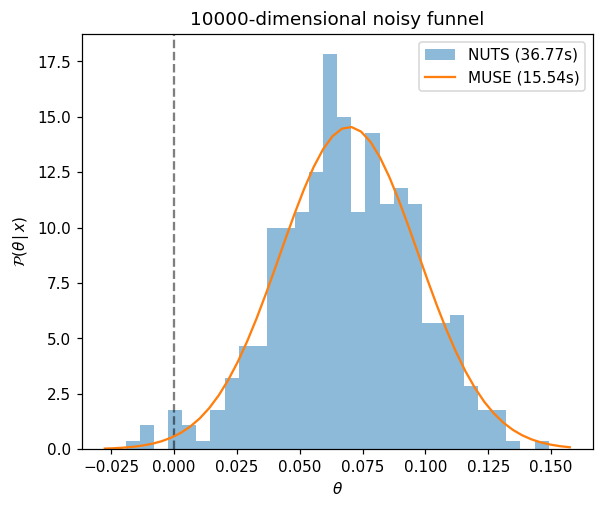

In [8]:
figure(figsize=(6,5))
axvline(0, c="k", ls="--", alpha=0.5)
hist(
    chain["posterior"]["θ"].to_series(), 
    bins=30, density=True, alpha=0.5, color="C0",
    label="NUTS (%.2fs)"%t_hmc
)
θs = linspace(*xlim())
plot(
    θs, stats.norm(result.θ, sqrt(result.Σ[0,0])).pdf(θs), 
    color="C1", label="MUSE (%.2fs)"%t_muse
)
legend()
xlabel(r"$\theta$")
ylabel(r"$\mathcal{P}(\theta\,|\,x)$")
title("10000-dimensional noisy funnel");

The timing difference is indicative of the speedups over HMC that are possible. These get even more dramatic as we increase dimensionality, and 1-3 orders of magnitude are not atypical for high-dimensional problems.
